In [1]:
import numpy as np
import torch
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import matplotlib.animation as animation
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
#Generate dataset
np.random.seed(45)
num_samples = 40
    
# Generate data
x1 = np.random.uniform(-1, 1, num_samples)
f_x = 3*x1 + 4
eps = np.random.randn(num_samples)
y = f_x + eps

In [3]:
# Convert numpy arrays to torch tensors and set them to require gradients
x1_torch = torch.tensor(x1, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)

# Initialize parameters theta0 and theta1 (e.g., with random values)
theta0 = torch.tensor(0.0, requires_grad=True)
theta1 = torch.tensor(0.0, requires_grad=True)

def linear_model(x, theta1, theta0):
    return theta1 * x + theta0

def mse_loss(y_pred, y_true):
    return torch.mean((y_pred - y_true) ** 2)

# Forward pass: Compute predictions and loss
y_pred = linear_model(x1_torch, theta1, theta0)
loss = mse_loss(y_pred, y_torch)

# Backward pass: Compute gradients
loss.backward()

# True gradients
true_gradient_theta0 = theta0.grad.item()
true_gradient_theta1 = theta1.grad.item()

print(f"True gradient (theta0): {true_gradient_theta0}")
print(f"True gradient (theta1): {true_gradient_theta1}")

True gradient (theta0): -7.447054386138916
True gradient (theta1): -1.0253016948699951


In [4]:
stochastic_gradients_theta0 = []
stochastic_gradients_theta1 = []

# Loop through each data point in the dataset
for i in range(num_samples):
    # Reset gradients to None instead of zero_grad()
    theta0.grad = None
    theta1.grad = None
    
    # Compute prediction and loss for a single point
    y_pred_single = linear_model(x1_torch[i], theta1, theta0)
    loss_single = mse_loss(y_pred_single, y_torch[i])
    
    # Compute gradients for this point
    loss_single.backward()
    
    # Store the gradients
    stochastic_gradients_theta0.append(theta0.grad.item())
    stochastic_gradients_theta1.append(theta1.grad.item())

# Calculate the average stochastic gradients
avg_stochastic_gradient_theta0 = np.mean(stochastic_gradients_theta0)
avg_stochastic_gradient_theta1 = np.mean(stochastic_gradients_theta1)

print(f"Avg stochastic gradient (theta0): {avg_stochastic_gradient_theta0}")
print(f"Avg stochastic gradient (theta1): {avg_stochastic_gradient_theta1}")

Avg stochastic gradient (theta0): -7.4470539569854735
Avg stochastic gradient (theta1): -1.0253017988055944


In [6]:
# Initialize storage for plotting paths
theta_paths_full_batch = []
theta_paths_stochastic = []
theta_paths_mini_batch = []

# Function to capture theta values across epochs for Full-Batch Gradient Descent
def full_batch_gradient_descent(x, y, learning_rate=0.01, epochs=15, epsilon=0.001):
    theta_0 = 0.0
    theta_1 = 0.0
    losses = []
    iterations = 0
    theta_paths = [(theta_0, theta_1)]  # Store initial values

    for epoch in range(epochs):
        y_pred = theta_1 * x + theta_0
        loss = np.mean((y - y_pred) ** 2)
        losses.append(loss)
        
        grad_theta_0 = -2 * np.mean(y - y_pred)
        grad_theta_1 = -2 * np.mean((y - y_pred) * x)
        
        new_theta_0 = theta_0 - learning_rate * grad_theta_0
        new_theta_1 = theta_1 - learning_rate * grad_theta_1
        
       
        if abs(new_theta_0 - theta_0) < epsilon and abs(new_theta_1 - theta_1) < epsilon:
            break
        
        theta_0 = new_theta_0
        theta_1 = new_theta_1
        
        iterations += 1  # Track number of iterations

        theta_paths.append((theta_0, theta_1))  # Store updated values

    theta_paths_full_batch.extend(theta_paths)  # Add paths for animation
    
    return losses, iterations, epoch+1

# Function to capture theta values for Stochastic Gradient Descent
def stochastic_gradient_descent(x, y, learning_rate=0.01, epochs=15, epsilon=0.001):
    theta_0 = 0.0
    theta_1 = 0.0
    losses = []
    iterations = 0
    theta_paths = [(theta_0, theta_1)]

    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(x)):
            y_pred = theta_1 * x[i] + theta_0
            loss = (y[i] - y_pred) ** 2
            total_loss += loss
            
            grad_theta_0 = -2 * (y[i] - y_pred)
            grad_theta_1 = -2 * (y[i] - y_pred) * x[i]
            
            new_theta_0 = theta_0 - learning_rate * grad_theta_0
            new_theta_1 = theta_1 - learning_rate * grad_theta_1
            
            # Check for parameter convergence
            if abs(new_theta_0 - theta_0) < epsilon and abs(new_theta_1 - theta_1) < epsilon:
                break
            
            theta_0 = new_theta_0
            theta_1 = new_theta_1

            iterations += 1
        
        avg_loss = total_loss / len(x)
        losses.append(avg_loss)
        theta_paths.append((theta_0, theta_1))  # Store theta values

    theta_paths_stochastic.extend(theta_paths)  # Add paths for animation
    return losses, iterations, epoch+1

# Function to capture theta values for Mini-Batch Gradient Descent
def mini_batch_gradient_descent(x, y, batch_size=8, learning_rate=0.01, epochs=15, epsilon=0.001):
    theta_0 = 0.0
    theta_1 = 0.0
    losses = []
    num_samples = len(x)
    iterations = 0
    theta_paths = [(theta_0, theta_1)]

    for epoch in range(epochs):
        total_loss = 0
        for i in range(0, num_samples, batch_size):
            x_batch = x[i:i+batch_size]
            y_batch = y[i:i+batch_size]
            
            y_pred = theta_1 * x_batch + theta_0
            loss = np.mean((y_batch - y_pred) ** 2)
            total_loss += loss
            
            grad_theta_0 = -2 * np.mean(y_batch - y_pred)
            grad_theta_1 = -2 * np.mean((y_batch - y_pred) * x_batch)
            
            new_theta_0 = theta_0 - learning_rate * grad_theta_0
            new_theta_1 = theta_1 - learning_rate * grad_theta_1
            
            # Check for parameter convergence
            if abs(new_theta_0 - theta_0) < epsilon and abs(new_theta_1 - theta_1) < epsilon:
                break
            
            theta_0 = new_theta_0
            theta_1 = new_theta_1

            iterations += 1
        
        avg_loss = total_loss / (num_samples / batch_size)
        losses.append(avg_loss)
        theta_paths.append((theta_0, theta_1))  # Store theta values

    theta_paths_mini_batch.extend(theta_paths)  # Add paths for animation
    return losses, iterations, epoch+1


In [7]:

losses_full_batch, iterations_fb, epochs_fb = full_batch_gradient_descent(x1, y)
losses_stochastic, iterations_sgd, epochs_sgd = stochastic_gradient_descent(x1, y)
losses_mini_batch, iterations_mb, epochs_mb = mini_batch_gradient_descent(x1, y)


epochs_sgd_corrected = iterations_sgd / len(x1)
epochs_mb_corrected = iterations_mb / (len(x1) / 5) 


print(f"Full-Batch Gradient Descent: {iterations_fb} iterations, Epochs till convergence: {epochs_fb}")
print(f"Stochastic Gradient Descent: {iterations_sgd} iterations, Epochs till convergence: {epochs_sgd_corrected:.2f}")
print(f"Mini-Batch Gradient Descent: {iterations_mb} iterations, Epochs till convergence: {epochs_mb_corrected:.2f}")

Full-Batch Gradient Descent: 15 iterations, Epochs till convergence: 15
Stochastic Gradient Descent: 285 iterations, Epochs till convergence: 7.12
Mini-Batch Gradient Descent: 75 iterations, Epochs till convergence: 9.38


<Figure size 800x600 with 0 Axes>

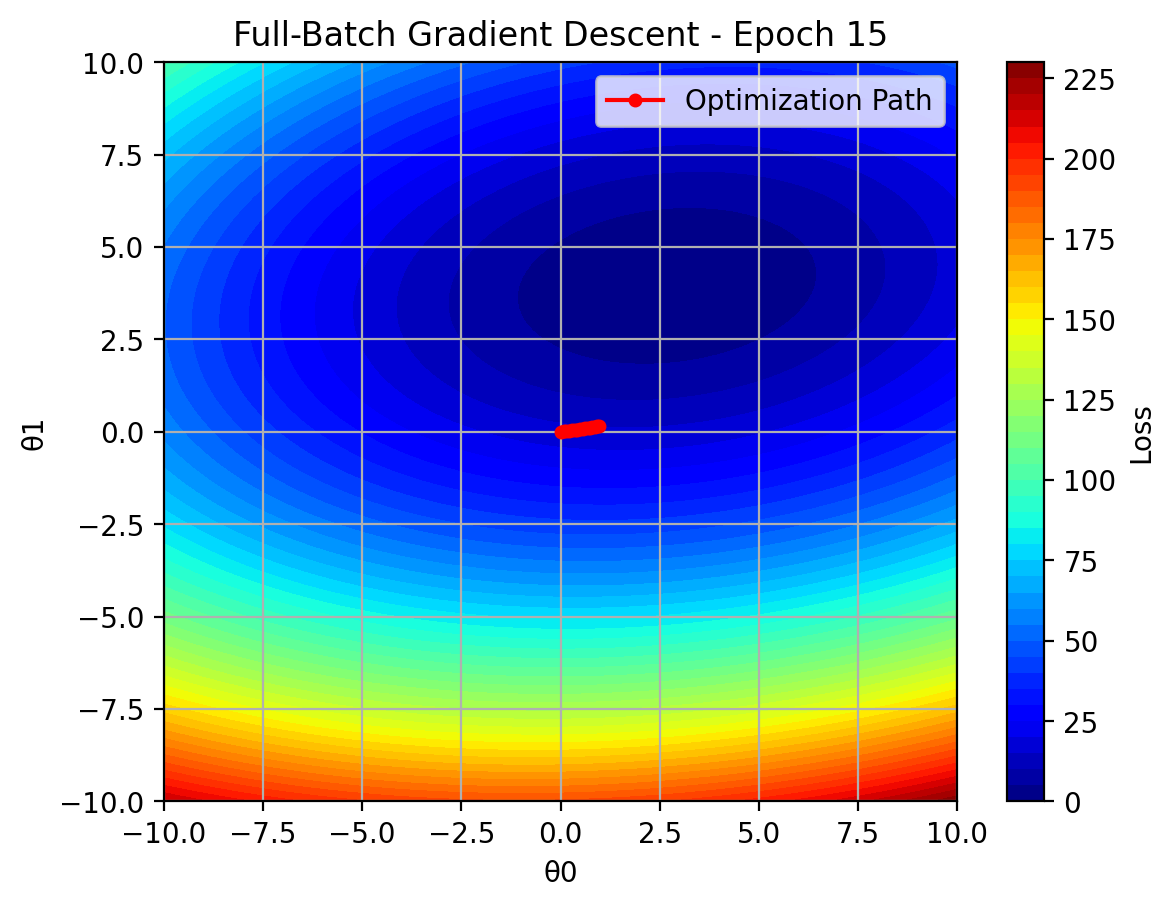

In [8]:
# Visualization of Contours and Optimization Paths

def plot_contours(x, y, theta_paths, title):
    theta_0_vals = np.linspace(-10, 10, 100)
    theta_1_vals = np.linspace(-10, 10, 100)
    loss_vals = np.zeros((len(theta_0_vals), len(theta_1_vals)))

    for i, t0 in enumerate(theta_0_vals):
        for j, t1 in enumerate(theta_1_vals):
            y_pred = t1 * x + t0
            loss = np.mean((y - y_pred) ** 2)
            loss_vals[i, j] = loss

    return theta_0_vals, theta_1_vals, loss_vals

theta_0_vals, theta_1_vals, loss_vals = plot_contours(x1, y, theta_paths_full_batch, "Full-Batch GD")

# Function to the plot for animation
def plot(epoch, theta_paths, contour):
    plt.clf()
    plt.contourf(theta_0_vals, theta_1_vals, loss_vals, levels=50, cmap='jet')
    plt.colorbar(label='Loss')
    
    theta_values = np.array(theta_paths[:epoch + 1])
    plt.plot(theta_values[:, 0], theta_values[:, 1], 'ro-', markersize=4, label='Optimization Path')
    plt.title(f'{contour} Gradient Descent - Epoch {epoch}')
    plt.xlabel('θ0')
    plt.ylabel('θ1')
    plt.legend()
    plt.grid(True)

fig = plt.figure(figsize=(8, 6))
ani_full_batch = FuncAnimation(fig, plot, frames=len(theta_paths_full_batch), 
                               fargs=(theta_paths_full_batch, 'Full-Batch'), interval=500)

plt.show()

ani_full_batch.save('fullbatch_gradient_descent.gif', writer='pillow')

<Figure size 800x600 with 0 Axes>

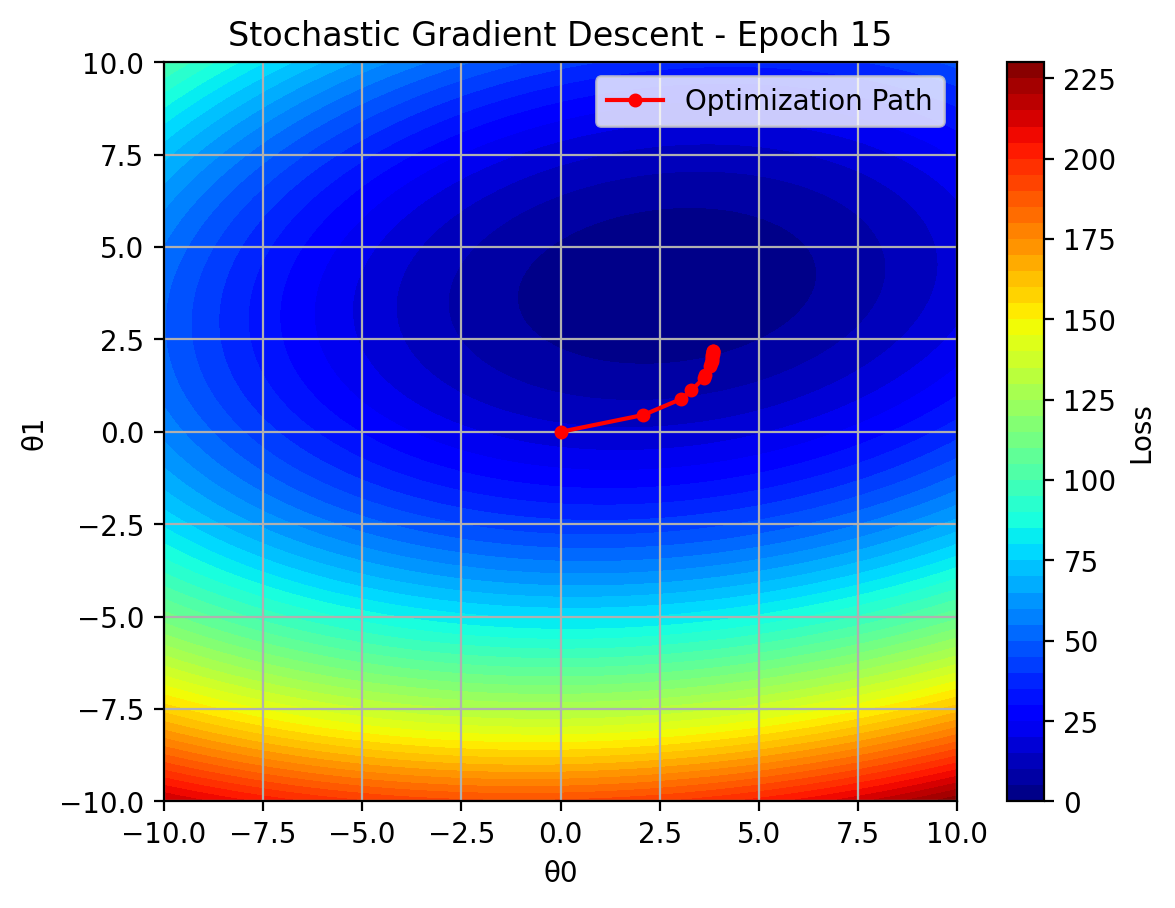

In [10]:
# Create animation for Stochastic Gradient Descent
fig_sgd = plt.figure(figsize=(8, 6))
ani_sgd = FuncAnimation(fig_sgd, plot, frames=len(theta_paths_stochastic), 
                        fargs=(theta_paths_stochastic, 'Stochastic'), interval=500)
plt.show()

ani_sgd.save('stochastic_gradient_descent.gif', writer='pillow')

<Figure size 800x600 with 0 Axes>

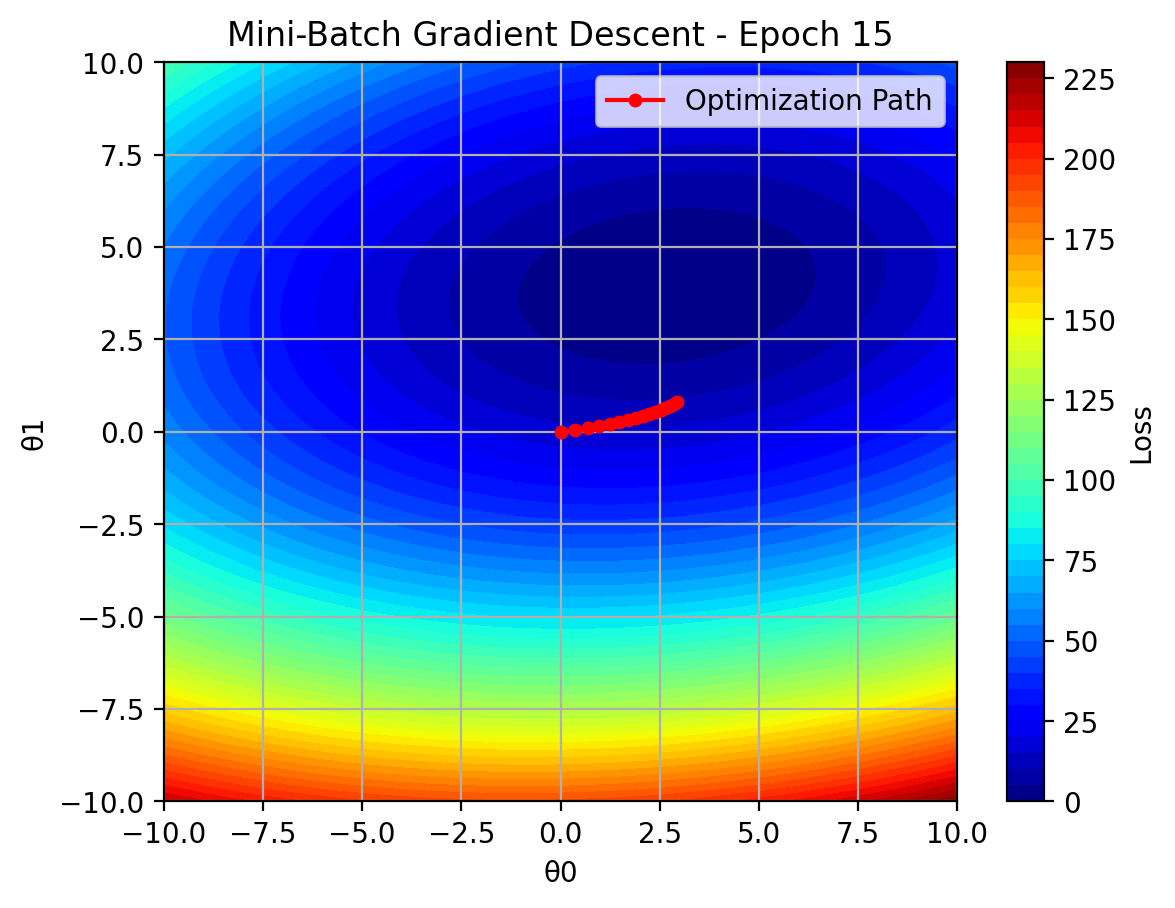

In [11]:
# Create animation for Mini-Batch Gradient Descent
fig_mini_batch = plt.figure(figsize=(8, 6))
ani_mini_batch = FuncAnimation(fig_mini_batch, plot, frames=len(theta_paths_mini_batch), 
                               fargs=(theta_paths_mini_batch, 'Mini-Batch'), interval=500)

plt.show()

ani_mini_batch.save('minibatch_gd.gif', writer='pillow')

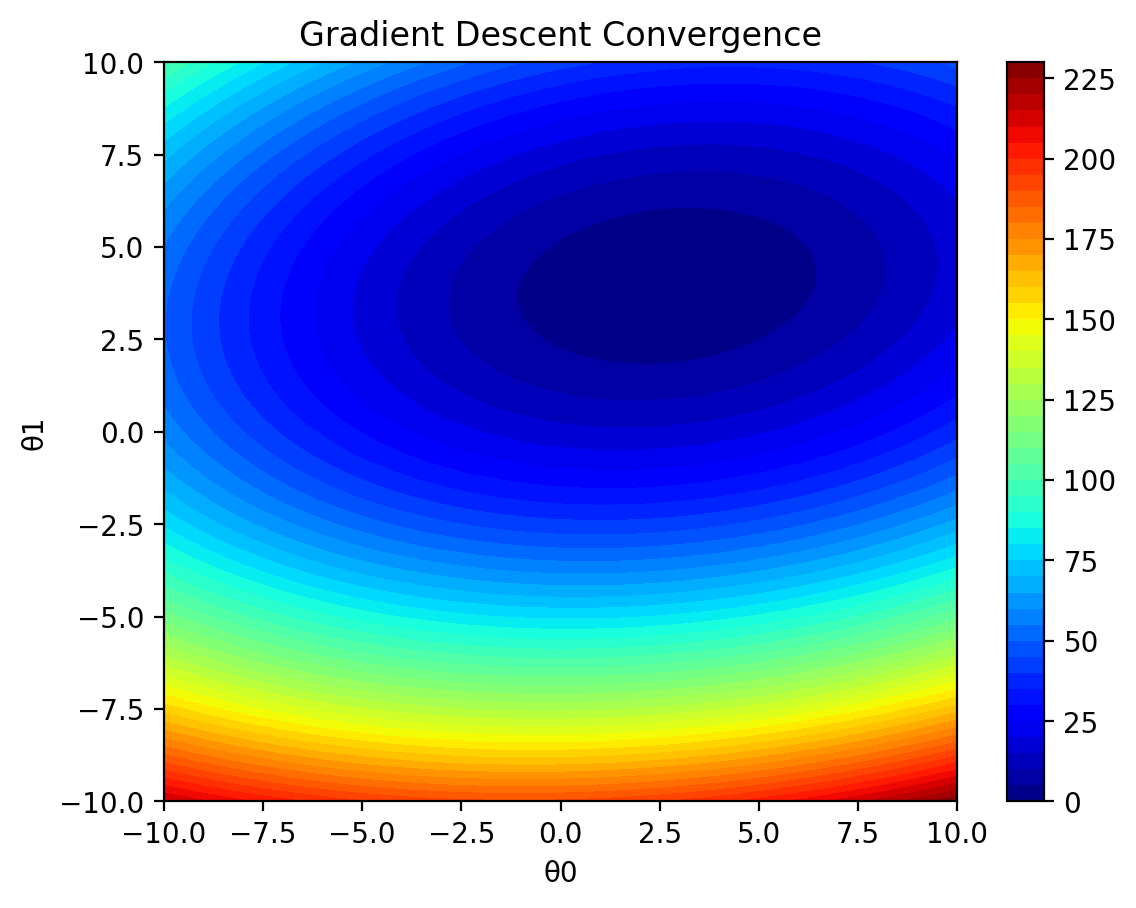

In [14]:
# Create a grid of values for theta_0 and theta_1
theta_0_vals = np.linspace(-10, 10, 100)
theta_1_vals = np.linspace(-10, 10, 100)

# Loss surface calculation
loss_surface = np.zeros((len(theta_0_vals), len(theta_1_vals)))

for i in range(len(theta_0_vals)):
    for j in range(len(theta_1_vals)):
        theta_0 = theta_0_vals[i]
        theta_1 = theta_1_vals[j]
        y_pred = theta_1 * x1 + theta_0
        loss_surface[i, j] = np.mean((y - y_pred) ** 2)

# Plot contour at different epochs
theta_0_grid, theta_1_grid = np.meshgrid(theta_0_vals, theta_1_vals)

plt.contourf(theta_0_grid, theta_1_grid, loss_surface, levels=50, cmap="jet")
plt.colorbar()
plt.xlabel('θ0')
plt.ylabel('θ1')
plt.title('Gradient Descent Convergence')
plt.show()

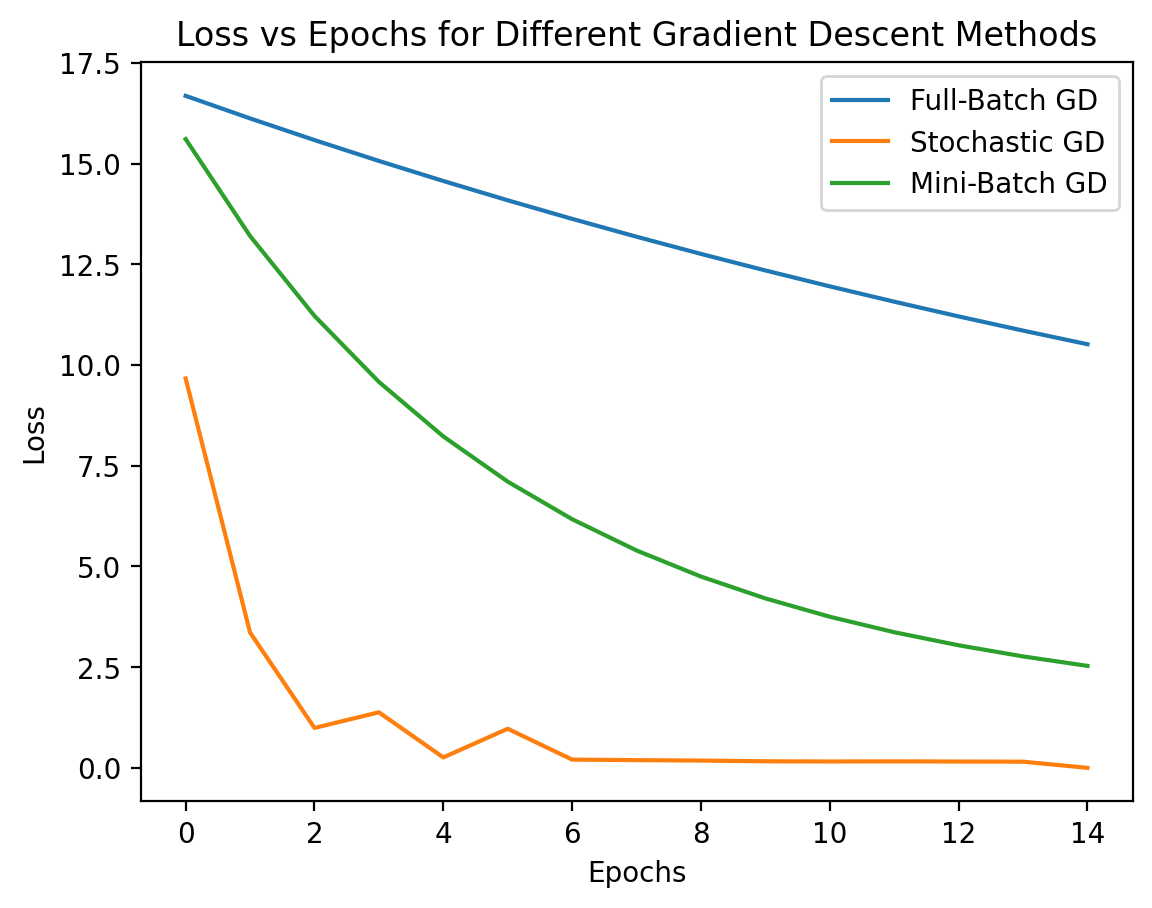

In [17]:
plt.plot(losses_full_batch, label="Full-Batch GD")
plt.plot(losses_stochastic, label="Stochastic GD")
plt.plot(losses_mini_batch, label="Mini-Batch GD")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss vs Epochs for Different Gradient Descent Methods")
plt.show()

In [18]:
# Gradient Descent with Momentum for Full-Batch Gradient Descent
def full_batch_gd_momentum(x, y, learning_rate=0.01, epochs=15, epsilon=0.001, beta=0.7):
    theta_0 = 0.0
    theta_1 = 0.0
    v_0 = 0.0  # Momentum for theta_0
    v_1 = 0.0  # Momentum for theta_1
    losses = []
    theta_paths = [(theta_0, theta_1)]  # Store initial values

    
    for epoch in range(epochs):
        y_pred = theta_1 * x + theta_0
        loss = np.mean((y - y_pred) ** 2)
        losses.append(loss)

        # Compute gradients
        grad_theta_0 = -2 * np.mean(y - y_pred)
        grad_theta_1 = -2 * np.mean((y - y_pred) * x)

        # Update velocities (momentum)
        v_0 = beta * v_0 + (1 - beta) * grad_theta_0
        v_1 = beta * v_1 + (1 - beta) * grad_theta_1

        # Update parameters
        theta_0 -= learning_rate * v_0
        theta_1 -= learning_rate * v_1

        theta_paths.append((theta_0, theta_1))  # Store updated values

        if loss < epsilon:
            break
    return losses, theta_paths

# Gradient Descent with Momentum for Stochastic Gradient Descent
def stochastic_gd_momentum(x, y, learning_rate=0.01, epochs=15, epsilon=0.001, beta=0.7):
    theta_0 = 0.0
    theta_1 = 0.0
    v_0 = 0.0  # Momentum for theta_0
    v_1 = 0.0  # Momentum for theta_1
    losses = []
    theta_paths = [(theta_0, theta_1)]  # Store initial values

    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(x)):
            y_pred = theta_1 * x[i] + theta_0
            loss = (y[i] - y_pred) ** 2
            total_loss += loss

            # Compute gradients
            grad_theta_0 = -2 * (y[i] - y_pred)
            grad_theta_1 = -2 * (y[i] - y_pred) * x[i]

            # Update velocities (momentum)
            v_0 = beta * v_0 + (1 - beta) * grad_theta_0
            v_1 = beta * v_1 + (1 - beta) * grad_theta_1

            # Update parameters
            theta_0 -= learning_rate * v_0
            theta_1 -= learning_rate * v_1

        avg_loss = total_loss / len(x)
        losses.append(avg_loss)
        theta_paths.append((theta_0, theta_1))  # Store updated values

        if avg_loss < epsilon:
            break
    return losses, theta_paths


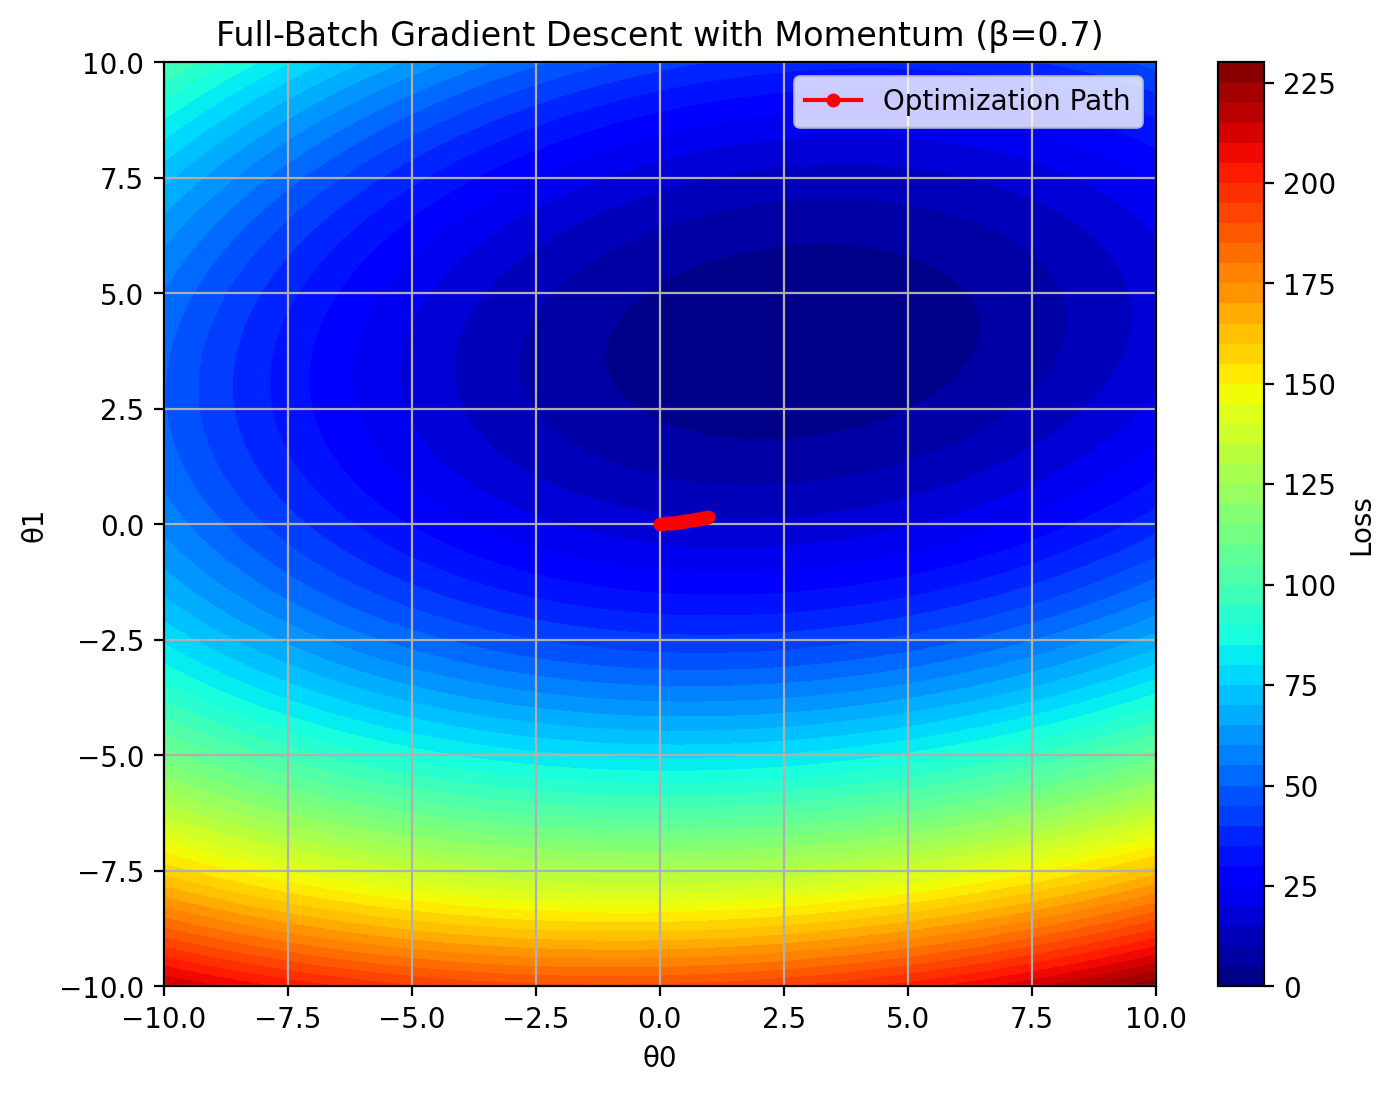

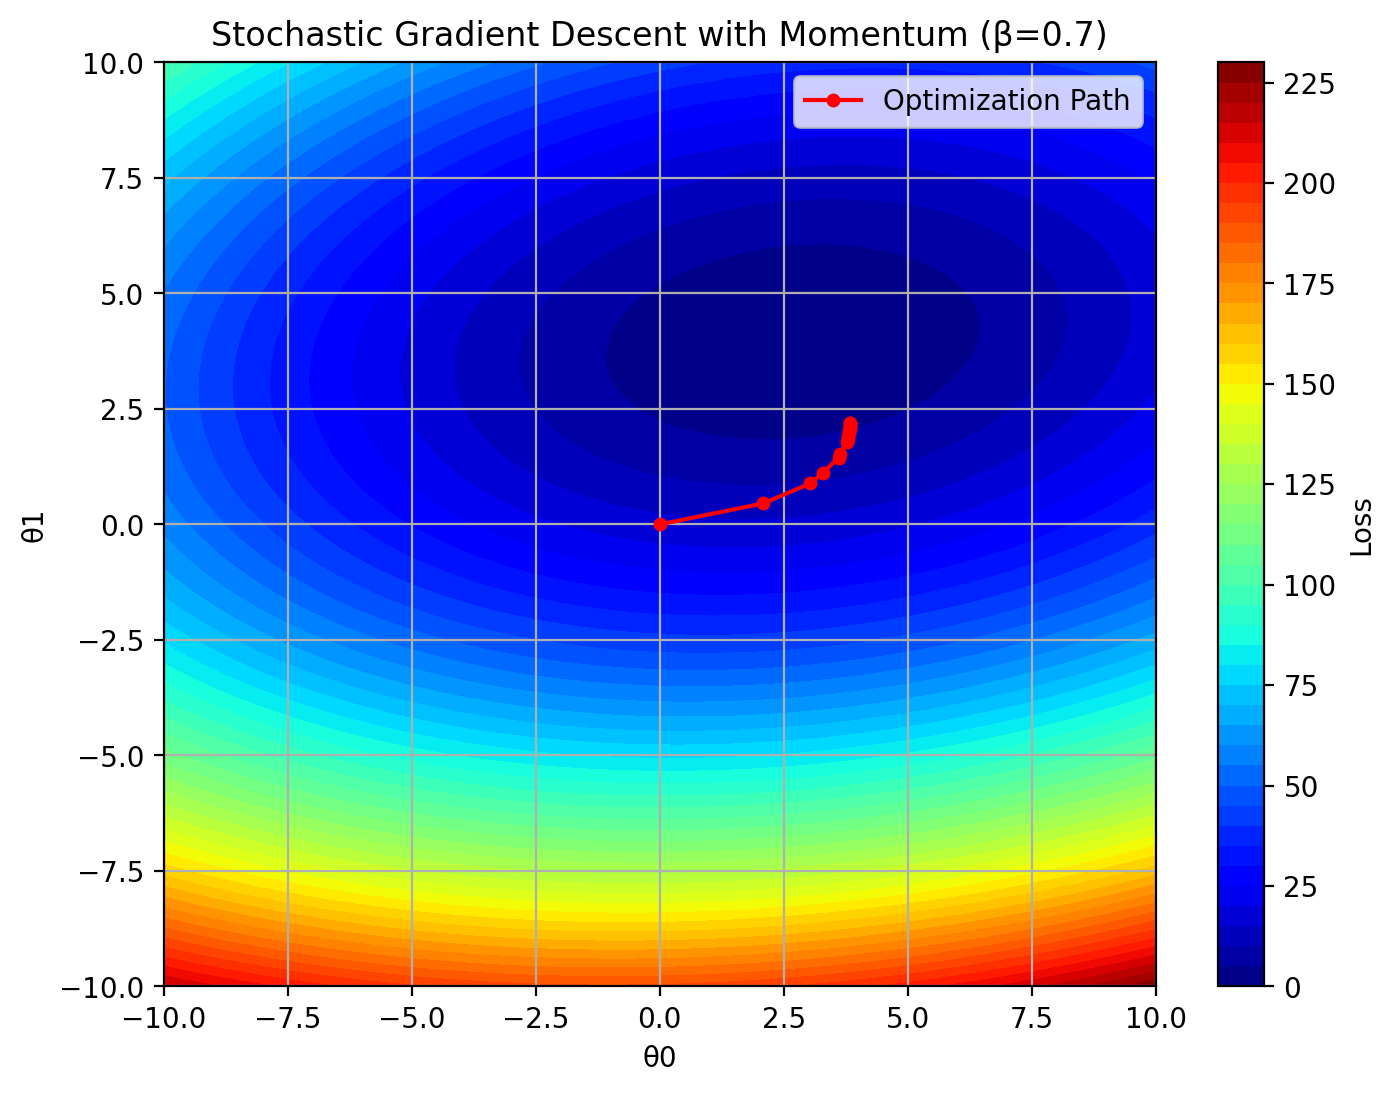

In [19]:
def plot_contours_with_momentum(x, y, theta_paths, title, beta=0.7):
    theta_0_vals = np.linspace(-10, 10, 100)
    theta_1_vals = np.linspace(-10, 10, 100)
    loss_vals = np.zeros((len(theta_0_vals), len(theta_1_vals)))

    for i, t0 in enumerate(theta_0_vals):
        for j, t1 in enumerate(theta_1_vals):
            y_pred = t1 * x + t0
            loss = np.mean((y - y_pred) ** 2)
            loss_vals[i, j] = loss

    # Plot contours and optimization path
    plt.contourf(theta_0_vals, theta_1_vals, loss_vals, levels=50, cmap='jet')
    plt.colorbar(label='Loss')

    theta_values = np.array(theta_paths)
    plt.plot(theta_values[:, 0], theta_values[:, 1], 'ro-', markersize=4, label='Optimization Path')
    plt.title(f'{title} Gradient Descent with Momentum (β={beta})')
    plt.xlabel('θ0')
    plt.ylabel('θ1')
    plt.legend()
    plt.grid(True)

# Create plots for each method
plt.figure(figsize=(8, 6))
plot_contours_with_momentum(x1, y, theta_paths_full_batch, 'Full-Batch')
plt.show()

plt.figure(figsize=(8, 6))
plot_contours_with_momentum(x1, y, theta_paths_stochastic, 'Stochastic')
plt.show()

Observation - The method of Gradient Descent with momentum seems to converge in lesser epochs than vanilla Gradient Descent.

We also expect a smoother optimization path than the vanilla version of the optimization algorithm but this was not so in our case because of reasons such as limited data size and due to the criteria that we use to declare convergence (this criteria is not an ideal one because if we have already obtained the optimal parameters by the normal equation than there is no point in trying to re-optimize using gradient descent)

We get a smoother optimization path because of the fact that the momentum algorithm is using a kind of a moving average of gradients in order to update the parameters which reduces the noise that a non-momentum algorithm might induce during optimization.

In [31]:
print(f"Full-Batch Gradient Descent:", {iterations_fb})

Full-Batch Gradient Descent: {15}


In [35]:
def gradient_descent_with_momentum(x, y, learning_rate=0.01, epochs=15, momentum=0.9, epsilon=0.001):
    theta_0 = 0.0
    theta_1 = 0.0
    losses = []
    iterations = 0
    theta_paths = [(theta_0, theta_1)]
    v_theta_0 = 0.0  # Initialize velocity for theta_0
    v_theta_1 = 0.0  # Initialize velocity for theta_1

    for epoch in range(epochs):
        y_pred = theta_1 * x + theta_0
        loss = np.mean((y - y_pred) ** 2)
        losses.append(loss)

        grad_theta_0 = -2 * np.mean(y - y_pred)
        grad_theta_1 = -2 * np.mean((y - y_pred) * x)

        # Update velocities
        v_theta_0 = momentum * v_theta_0 - learning_rate * grad_theta_0
        v_theta_1 = momentum * v_theta_1 - learning_rate * grad_theta_1

        # Update parameters
        new_theta_0 = theta_0 + v_theta_0
        new_theta_1 = theta_1 + v_theta_1

        # Debugging: Print gradients and new parameters
        print(f"Epoch: {epoch+1}, Gradients: ({grad_theta_0}, {grad_theta_1}), "
              f"New Params: ({new_theta_0}, {new_theta_1}), Loss: {loss}")

        # Check for convergence
        if abs(new_theta_0 - theta_0) < epsilon and abs(new_theta_1 - theta_1) < epsilon:
            break

        theta_0 = new_theta_0
        theta_1 = new_theta_1
        iterations += 1
        
        theta_paths.append((theta_0, theta_1))  # Store updated values

    theta_paths_momentum.extend(theta_paths)  # Add paths for animation
    
    return losses, iterations, epoch + 1

# Run the function and print the results
losses_gdm, iterations_gdm, _ = gradient_descent_with_momentum(x1, y, learning_rate=0.01, epochs=15, momentum=0.9, epsilon=0.001)

# Compare iterations for all methods
print("Iterations for Full-Batch Gradient Descent: ", iterations_fb)
print("Iterations for Gradient Descent with Momentum: ", iterations_gdm)

# Store results for comparison
average_steps = {
    "Full-Batch Gradient Descent": iterations_fb,
    "Stochastic Gradient Descent": iterations_sgd,
    "Mini-Batch Gradient Descent": iterations_mb,
    "Gradient Descent with Momentum": iterations_gdm
}

print("\nAverage steps taken to converge to ε-neighborhood:")
for method, steps in average_steps.items():
    print(f"{method}: {steps}")


Epoch: 1, Gradients: (-7.447053920097926, -1.0253017532346629), New Params: (0.07447053920097926, 0.010253017532346628), Loss: 16.68148600324362
Epoch: 2, Gradients: (-7.2998495065885525, -1.0314389580318855), New Params: (0.21449251954774615, 0.029795122891777447), Loss: 16.121837179092513
Epoch: 3, Gradients: (-7.023115604440986, -1.0428115432386442), New Params: (0.41074345790424627, 0.05781113314765163), Loss: 15.098804598531668
Epoch: 4, Gradients: (-6.635359103544244, -1.0583553976279572), New Params: (0.6537228934605388, 0.09360909635421796), Loss: 13.729127202269046
Epoch: 5, Gradients: (-6.155463722104893, -1.0768984207787111), New Params: (0.933959022682251, 0.13659624744791476), Loss: 12.13695487821666
Epoch: 6, Gradients: (-5.60227266413744, -1.097210711383046), New Params: (1.2421942656231664, 0.18625679054607236), Loss: 10.442754232692531
Epoch: 7, Gradients: (-4.994213723585866, -1.1180500332193375), New Params: (1.5695481215058489, 0.24213177966660757), Loss: 8.75464342